In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing
import tensorflow as tf

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

In [5]:
# from google.colab import files 
# upload = files.upload()

In [6]:
#baca data
data = pd.read_csv('data_nlp.csv')

# Keeping only the neccessary columns
data = data[['ID','kategori','isi_laporan','sentimen']]
data

,ID,kategori,isi_laporan,sentimen
0,1,Fisik,Ibu saya sering pingsan dipukuli oleh ayah sam...,High
1,2,Psikis,"Sejak kecil, ayah saya tidak menyukai penampil...",High
2,3,Seksual,Pagi tadi saya iseng mengunggah sebuah foto se...,High
3,4,Seksual,ANAK SAYA DIGERAYANGI OLEH LAKI-LAKI TIDAK DIK...,High
4,5,Fisik,Ada kasus pencabulan di SLB dekat rumah. Belum...,High
...,...,...,...,...
495,496,Seksual,"Saya benci dengan kakak ipar saya, dia suka me...",High
496,497,penelantaran,Ayah saya pergi dan tidak pernah kembali karen...,High
497,498,Fisik,"Kenalan saya mengadopsi anak, tapi karena anak...",High
498,499,Seksual,Kemarin saya bertemu lagi dengan teman SMA yan...,High


In [7]:
data.isnull().sum()

ID             0
kategori       0
isi_laporan    0
sentimen       0
dtype: int64

In [8]:
data = data[data.sentimen != "Medium"]

data['isi_laporan'] = data['isi_laporan'].apply(lambda x: x.lower())
data['isi_laporan'] = data['isi_laporan'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
    
# for idx,row in data.iterrows():
# row[0] = row[0].replace('rt',' ')

data.head()

,ID,kategori,isi_laporan,sentimen
0,1,Fisik,ibu saya sering pingsan dipukuli oleh ayah sam...,High
1,2,Psikis,sejak kecil ayah saya tidak menyukai penampila...,High
2,3,Seksual,pagi tadi saya iseng mengunggah sebuah foto se...,High
3,4,Seksual,anak saya digerayangi oleh lakilaki tidak dike...,High
4,5,Fisik,ada kasus pencabulan di slb dekat rumah belum ...,High


In [9]:
#Checking total data
print(len(data[data.sentimen == "High"]))
print(len(data[data.sentimen == "Low"]))

333
167


In [10]:
max_features = 3000

tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['isi_laporan'].values)
X = tokenizer.texts_to_sequences(data['isi_laporan'].values)
X = pad_sequences(X)

In [11]:
Y = pd.get_dummies(data['sentimen']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(400, 53) (400, 2)
(100, 53) (100, 2)


In [12]:
# kategori = pd.get_dummies(data.sentimen)
# data = pd.concat([data, kategori], axis=1 )
# data = data.drop(columns=['ID', 'kategori','sentimen'])
data = data.drop(columns=['ID', 'kategori'])
data

,isi_laporan,sentimen
0,ibu saya sering pingsan dipukuli oleh ayah sam...,High
1,sejak kecil ayah saya tidak menyukai penampila...,High
2,pagi tadi saya iseng mengunggah sebuah foto se...,High
3,anak saya digerayangi oleh lakilaki tidak dike...,High
4,ada kasus pencabulan di slb dekat rumah belum ...,High
...,...,...
495,saya benci dengan kakak ipar saya dia suka men...,High
496,ayah saya pergi dan tidak pernah kembali karen...,High
497,kenalan saya mengadopsi anak tapi karena anak ...,High
498,kemarin saya bertemu lagi dengan teman sma yan...,High


In [13]:
y_train = to_categorical(Y_train, 2)
y_test = to_categorical(Y_test, 2)

In [14]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D (0.5))
model.add(LSTM(lstm_out, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(2,activation='sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 53, 128)           384000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 53, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense (Dense)                (None, 2)                 394       
Total params: 639,194
Trainable params: 639,194
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
#Implementasi Callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [16]:
# model.fit(X_train, Y_train, epochs=15, callbacks=[callbacks])

In [17]:
batch_size = 32
history = model.fit(X_train, Y_train, 
                    epochs = 15, 
                    batch_size=batch_size, 
                    validation_data=(X_test, Y_test),
                    verbose = 1,
                    callbacks=[callbacks])

Epoch 1/15
13/13 [==============================] - 32s 409ms/step - loss: 0.6837 - accuracy: 0.6157 - val_loss: 0.6343 - val_accuracy: 0.7100
Epoch 2/15
13/13 [==============================] - 4s 307ms/step - loss: 0.6436 - accuracy: 0.6657 - val_loss: 0.5991 - val_accuracy: 0.7100
Epoch 3/15
13/13 [==============================] - 4s 309ms/step - loss: 0.6064 - accuracy: 0.6815 - val_loss: 0.5958 - val_accuracy: 0.7100
Epoch 4/15
13/13 [==============================] - 4s 312ms/step - loss: 0.5642 - accuracy: 0.6709 - val_loss: 0.6223 - val_accuracy: 0.6200
Epoch 5/15
13/13 [==============================] - 4s 321ms/step - loss: 0.4593 - accuracy: 0.8075 - val_loss: 0.6169 - val_accuracy: 0.7200
Epoch 6/15
13/13 [==============================] - 4s 308ms/step - loss: 0.3893 - accuracy: 0.8417 - val_loss: 0.4744 - val_accuracy: 0.8200
Epoch 7/15
13/13 [==============================] - 4s 308ms/step - loss: 0.3045 - accuracy: 0.8855 - val_loss: 0.5134 - val_accuracy: 0.7900
Epoch

In [18]:
score = model.evaluate(X_test, Y_test, verbose=False)
print("loss = ",score[0])
print("accuracy = ",score[1])

loss =  0.4141545593738556
accuracy =  0.8399999737739563


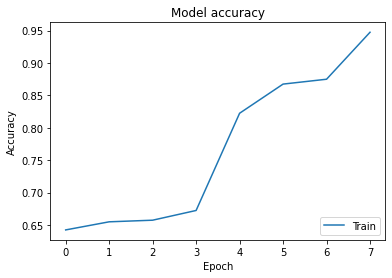

In [19]:
#melakukan plot untuk model accuracy pada training data 
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

In [20]:
def printpred(sample):
  sample = tokenizer.texts_to_sequences(sample)
  sample = pad_sequences(sample, maxlen=53, dtype='int32', value=0)
  sentimen = model.predict(sample,batch_size=1,verbose = 2)[0]
  if(np.argmax(sentimen) == 0):
    print("Low")
  elif (np.argmax(sentimen) == 1):
    print("High")

In [21]:
#Prediksi Hasil Model
sample1 = ["Suami sangat kasar dan sering melakukan KDRT terhadap saya"]
sample2 = ["Saya menemukan bayi di kolong jembatan. Sepertinya baru dibuang tadi malam"]

print("".join(sample1))
printpred(sample1)

print("".join(sample2))
printpred(sample2)

Suami sangat kasar dan sering melakukan KDRT terhadap saya
1/1 - 1s
High
Saya menemukan bayi di kolong jembatan. Sepertinya baru dibuang tadi malam
1/1 - 0s
Low


In [22]:
import json
json.dumps(tokenizer.word_index)

'{"saya": 1, "dan": 2, "di": 3, "sering": 4, "anak": 5, "oleh": 6, "tidak": 7, "dengan": 8, "yang": 9, "dia": 10, "aku": 11, "ibu": 12, "karena": 13, "untuk": 14, "rumah": 15, "suka": 16, "tetangga": 17, "sangat": 18, "suami": 19, "sekolah": 20, "ke": 21, "melakukan": 22, "saat": 23, "pada": 24, "ayah": 25, "tapi": 26, "sekarang": 27, "ada": 28, "ini": 29, "orang": 30, "teman": 31, "ingin": 32, "mereka": 33, "kekerasan": 34, "jika": 35, "pernah": 36, "diperkosa": 37, "x": 38, "pulang": 39, "setiap": 40, "sudah": 41, "mau": 42, "adik": 43, "dari": 44, "ia": 45, "kemarin": 46, "itu": 47, "hingga": 48, "sedang": 49, "masih": 50, "hari": 51, "kalau": 52, "dalam": 53, "ketika": 54, "melihat": 55, "sama": 56, "fisik": 57, "akan": 58, "ternyata": 59, "trauma": 60, "juga": 61, "sampai": 62, "kasar": 63, "padahal": 64, "seorang": 65, "anaknya": 66, "dipaksa": 67, "kakak": 68, "banget": 69, "sakit": 70, "selalu": 71, "bahwa": 72, "merasa": 73, "melaporkan": 74, "tolong": 75, "takut": 76, "lakila

In [23]:
pip install tensorflowjs

     |████████████████████████████████| 71kB 2.1MB/s 


In [24]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, 'models')